In [2]:
import os
import pathlib
import warnings

import pandas as pd
import numpy as np
import json

import statsmodels.api as sm
import statsmodels.formula.api as smf

# plotting
from mplsoccer import Pitch
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [25]:
df = pd.DataFrame()
file_name = 'events_England.json'
path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'data', 'Wyscout', 'events', file_name)
with open(path) as f:
    data = json.load(f)
df = pd.concat([df, pd.DataFrame(data)])
df = df.reset_index()

In [26]:
df.head()

,index,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172
2,2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173
3,3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174
4,4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175


In [27]:
next_event = df.shift(-1, fill_value=0)
df["nextEvent"] = next_event["subEventName"]
df["kickedOut"] = df.apply(lambda x: 1 if x.nextEvent == "Ball out of the field" else 0, axis = 1)

#interruptions out
interruption = df.loc[df["eventName"] == "Interruption"]
#probably need to drop "others on the ball event" - nope

# filter out non-accurate duels - in wyscout they are 2 way - attacking and defending
lost_duels = df.loc[df["eventName"] == "Duel"]
lost_duels = lost_duels.loc[lost_duels.apply (lambda x:{'id':1802} in x.tags, axis = 1)]
df = df.drop(lost_duels.index)

# filter ball out of the field - I can get this anyway
out_of_ball = df.loc[df["subEventName"] == "Ball out of the field"]
df = df.drop(out_of_ball.index)

# save attempts can be dropped
goalies = df.loc[df["subEventName"].isin(["Goalkeeper leaving line", "Save attempt", "Reflexes"])]
df = df.drop(goalies.index)

In [28]:
df.head()

,index,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,nextEvent,kickedOut
0,0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,High pass,0
1,1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,Head pass,0
2,2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,Head pass,0
3,3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,Simple pass,0
4,4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,Simple pass,0


In [29]:
def isolateChains(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    df: dataframe
        dataframe with isolated possession chains

    """
    df["nextTeamId"] = df.shift(-1, fill_value=0)["teamId"]
    #potential +0s
    chain_team = df.iloc[0]["teamId"]
    period = df.iloc[0]["matchPeriod"]
    stop_criterion = 0
    chain = 0
    df["possession_chain"] = 0
    df["possession_chain_team"] = 0

    for i, row in df.iterrows():
        #add value
        df.at[i, "possession_chain"] = chain
        df.at[i, "possession_chain_team"] = chain_team
        # if pass not accurate/lost duel, add 1 to stop criterion
        if row["eventName"] == "Pass" or row["eventName"] == "Duel":
            if row["teamId"] == chain_team and {"id": 1802} in row["tags"]:
                stop_criterion += 1
            if row["teamId"] != chain_team and {"id": 1801} in row["tags"]:
                stop_criterion += 1
        #if ball intercepted, add 2 to stop criterion
        if row["eventName"] == "Others on the ball":
            if row["teamId"] == row["nextTeamId"]:
                stop_criterion += 2
        #if shot, add 2 to stop criterion
        if row["eventName"] in ["Shot", "Foul", "Offside"]:
            stop_criterion += 2
        #if ball out of field, add 2 to stop criterion
        if row["kickedOut"] == 1:
            stop_criterion += 2
        #criterion for stopping when half ended
        if row["matchPeriod"] != period:
            chain += 1
            stop_criterion = 0
            chain_team = row['teamId']
            period = row["matchPeriod"]
            df.at[i, "possession_chain"] = chain
            df.at[i, "possession_chain_team"] = chain_team
        #possession chain ended
        if stop_criterion >= 2:
            chain += 1
            stop_criterion = 0
            chain_team = row['nextTeamId']
    return df

df = isolateChains(df)
#investigate a chain
df.loc[df["possession_chain"] == 4][["eventName", "possession_chain"]]

,eventName,possession_chain
36,Free Kick,4
37,Pass,4
38,Duel,4
40,Duel,4
42,Pass,4
43,Pass,4
44,Pass,4
45,Pass,4
46,Shot,4


In [30]:
df.head()

,index,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,nextEvent,kickedOut,nextTeamId,possession_chain,possession_chain_team
0,0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,High pass,0,1609,0,1609
1,1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,Head pass,0,1609,0,1609
2,2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,Head pass,0,1609,0,1609
3,3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,Simple pass,0,1609,0,1609
4,4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,Simple pass,0,1609,0,1609


In [31]:
def calulatexG(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    xG_sum: dataframe
        dataframe with xG for each shot

    """
    #very basic xG model based on
    shots = df.loc[df["eventName"] == "Shot"].copy()
    shots["X"] = shots.positions.apply(lambda cell: (100 - cell[0]['x']) * 105/100)
    shots["Y"] = shots.positions.apply(lambda cell: cell[0]['y'] * 68/100)
    shots["C"] = shots.positions.apply(lambda cell: abs(cell[0]['y'] - 50) * 68/100)
    
    #calculate distance and angle
    shots["Distance"] = np.sqrt(shots["X"]**2 + shots["C"]**2)
    shots["Angle"] = np.where(np.arctan(7.32 * shots["X"] / (shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) > 0, 
                              np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)), 
                              np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) + np.pi)
    
    #if you ever encounter problems (like you have seen that model treats 0 as 1 and 1 as 0) while modelling - change the dependant variable to object
    shots["Goal"] = shots.tags.apply(lambda x: 1 if {'id':101} in x else 0).astype(object)
    
    #headers have id = 403
    headers = shots.loc[shots.apply (lambda x:{'id':403} in x.tags, axis = 1)]
    non_headers = shots.drop(headers.index)
    headers_model = smf.glm(formula="Goal ~ Distance + Angle" , data=headers, family=sm.families.Binomial()).fit()
    nonheaders_model = smf.glm(formula="Goal ~ Distance + Angle" , data=non_headers, family=sm.families.Binomial()).fit()
    
    #assigning xG
    df["xG"] = 0.0
    #headers
    b_head = headers_model.params
    xG = 1/(1+np.exp(b_head[0]+b_head[1]*headers['Distance'] + b_head[2]*headers['Angle']))
    headers = headers.assign(xG = xG)
    for index, row in headers.iterrows():
        df.at[index, "xG"] = row["xG"]
    #non-headers
    b_nhead = nonheaders_model.params
    xG = 1/(1+np.exp(b_nhead[0]+b_nhead[1]*non_headers['Distance'] + b_nhead[2]*non_headers['Angle']))
    non_headers = non_headers.assign(xG = xG)
    for index, row in non_headers.iterrows():
        df.at[index, "xG"] = row["xG"]

    penalties = df.loc[df["subEventName"] == "Penalty"]
    #treating penalties like shots
    penalties["X"] = 11
    #calculate distance and angle
    penalties["Distance"] = 11
    penalties["Angle"] = np.arctan(7.32 * 11 /(11**2 - (7.32/2)**2))
    #if you ever encounter problems (like you have seen that model treats 0 as 1 and 1 as 0) while modelling - change the dependant variable to object
    penalties["Goal"] = penalties.tags.apply(lambda x: 1 if {'id':101} in x else 0).astype(object)
    penalties = penalties.assign(xG = xG)
    for index, row in penalties.iterrows():
        df.at[index, "xG"] = row["xG"]
    return df

df = calulatexG(df)
#investigate a chain
df.loc[df["possession_chain"].isin([3,4])][["eventName", "possession_chain", "xG"]]

,eventName,possession_chain,xG
25,Pass,3,0.000000
26,Pass,3,0.000000
27,Duel,3,0.000000
30,Duel,3,0.000000
31,Duel,3,0.000000
34,Duel,3,0.000000
35,Foul,3,0.000000
36,Free Kick,4,0.000000
37,Pass,4,0.000000
38,Duel,4,0.000000


In [44]:
df.loc[df["possession_chain"].isin([0,1,3,4])][["eventName", "possession_chain", "possession_chain_team", "xG", "shot_end"]]

,eventName,possession_chain,possession_chain_team,xG,shot_end
0,Pass,0,1609,0.000000,0
1,Pass,0,1609,0.000000,0
2,Pass,0,1609,0.000000,0
3,Pass,0,1609,0.000000,0
4,Pass,0,1609,0.000000,0
5,Pass,0,1609,0.000000,0
8,Duel,1,1609,0.000000,0
9,Pass,1,1609,0.000000,0
10,Pass,1,1609,0.000000,0
11,Pass,1,1609,0.000000,0


In [34]:
df.head()

,index,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,nextEvent,kickedOut,nextTeamId,possession_chain,possession_chain_team,xG,shot_end
0,0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,High pass,0,1609,0,1609,0.0,0
1,1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,Head pass,0,1609,0,1609,0.0,0
2,2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,Head pass,0,1609,0,1609,0.0,0
3,3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,Simple pass,0,1609,0,1609,0.0,0
4,4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,Simple pass,0,1609,0,1609,0.0,0


In [36]:
#filter out dodgy
df = df.loc[df.apply(lambda x: len(x.positions) == 2, axis = 1)]

#columns with coordinates for plotting
df["x0"] = df.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
df["c0"] = df.positions.apply(lambda cell: abs(50 - cell[0]['y']) * 68/100)
df["x1"] = df.positions.apply(lambda cell: (cell[1]['x']) * 105/100)
df["c1"] = df.positions.apply(lambda cell: abs(50 - cell[1]['y']) * 68/100)
df["y0"] = df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
df["y1"] = df.positions.apply(lambda cell: (100 - cell[1]['y']) * 68/100)

#assign (105, 0) to end of the shot
df.loc[df["eventName"] == "Shot", "x1"] = 105
df.loc[df["eventName"] == "Shot", "c1"] = 0
df.loc[df["eventName"] == "Shot", "y1"] = 34

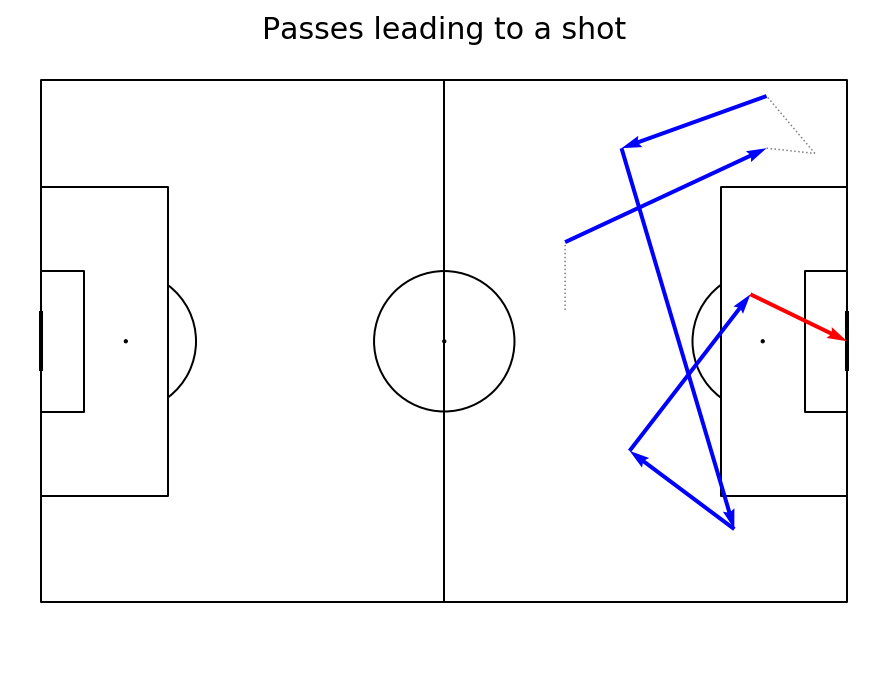

In [48]:
#plot possession chain that ended with shot
chain = df.loc[df["possession_chain"] == 4]
#get passes
passes = chain.loc[chain["eventName"].isin(["Pass"])]
#get events different than pass
not_pass = chain.loc[chain["eventName"] != "Pass"].iloc[:-1]
#shot is the last event of the chain (or should be)
shot = chain.iloc[-1]

#plot
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder=2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
#passes
pitch.arrows(passes.x0, passes.y0, passes.x1, passes.y1, color="blue", ax=ax['pitch'], zorder=3)
#shot
pitch.arrows(shot.x0, shot.y0,shot.x1, shot.y1, color="red", ax=ax['pitch'], zorder=3)
#other actions like duels
pitch.lines(not_pass.x0, not_pass.y0, not_pass.x1, not_pass.y1, color="grey", linewidth=1.5, linestyle='dotted', ax=ax['pitch'])

ax['title'].text(0.5, 0.5, 'Passes leading to a shot', ha='center', va='center', fontsize=30)
plt.show()

In [49]:
chain

,index,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,...,possession_chain,possession_chain_team,xG,shot_end,x0,c0,x1,c1,y0,y1
36,36,3,Free Kick,[{'id': 1801}],0,"[{'y': 44, 'x': 65}, {'y': 31, 'x': 65}]",2499719,Free Kick,1609,1H,...,4,1609,0.137573,1,68.25,4.08,68.25,12.92,38.08,46.92
37,37,8,Simple pass,[{'id': 1801}],49876,"[{'y': 31, 'x': 65}, {'y': 13, 'x': 90}]",2499719,Pass,1609,1H,...,4,1609,0.137573,1,68.25,12.92,94.50,25.16,46.92,59.16
38,38,1,Ground attacking duel,"[{'id': 502}, {'id': 703}, {'id': 1801}]",7868,"[{'y': 13, 'x': 90}, {'y': 14, 'x': 96}]",2499719,Duel,1609,1H,...,4,1609,0.137573,1,94.50,25.16,100.80,24.48,59.16,58.48
40,40,1,Ground attacking duel,"[{'id': 501}, {'id': 703}, {'id': 1801}]",7868,"[{'y': 14, 'x': 96}, {'y': 3, 'x': 90}]",2499719,Duel,1609,1H,...,4,1609,0.137573,1,100.80,24.48,94.50,31.96,58.48,65.96
42,42,8,Simple pass,[{'id': 1801}],7868,"[{'y': 3, 'x': 90}, {'y': 13, 'x': 72}]",2499719,Pass,1609,1H,...,4,1609,0.137573,1,94.50,31.96,75.60,25.16,65.96,59.16
43,43,8,High pass,[{'id': 1801}],49876,"[{'y': 13, 'x': 72}, {'y': 86, 'x': 86}]",2499719,Pass,1609,1H,...,4,1609,0.137573,1,75.60,25.16,90.30,24.48,59.16,9.52
44,44,8,Simple pass,[{'id': 1801}],167145,"[{'y': 86, 'x': 86}, {'y': 71, 'x': 73}]",2499719,Pass,1609,1H,...,4,1609,0.137573,1,90.30,24.48,76.65,14.28,9.52,19.72
45,45,8,Cross,"[{'id': 301}, {'id': 402}, {'id': 801}, {'id':...",120339,"[{'y': 71, 'x': 73}, {'y': 41, 'x': 88}]",2499719,Pass,1609,1H,...,4,1609,0.137573,1,76.65,14.28,92.40,6.12,19.72,40.12
46,46,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",25413,"[{'y': 41, 'x': 88}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,...,4,1609,0.137573,1,92.40,6.12,105.00,0.00,40.12,34.00


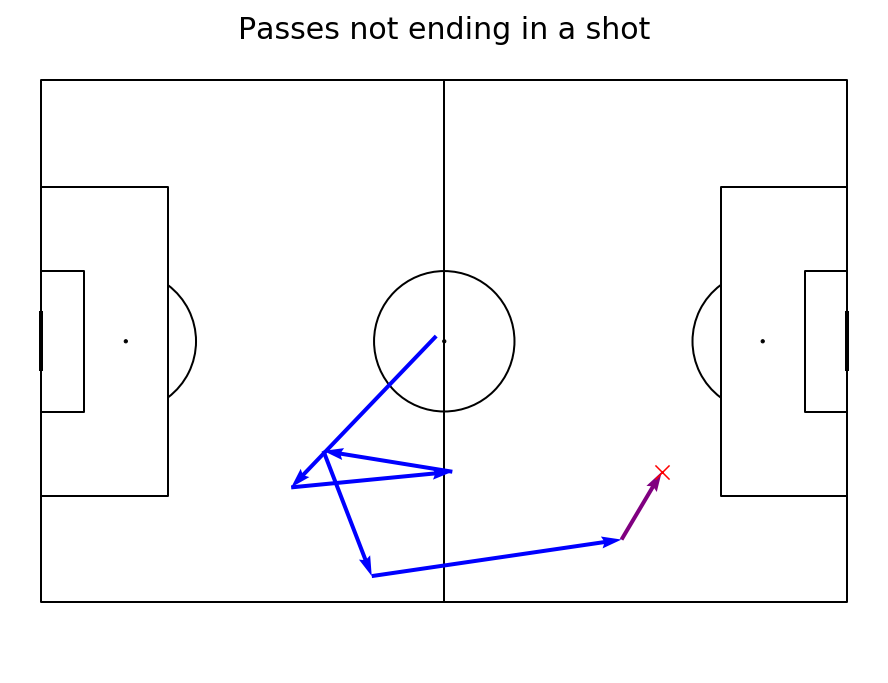

In [46]:
#plot possession chain that did not with shot
chain = df.loc[df["possession_chain"] == 0]
passes = chain.loc[chain["eventName"].isin(["Pass", "Free Kick"])].iloc[:-1]
not_pass = chain.loc[(chain["eventName"] != "Pass") & (chain["eventName"] != "Free Kick")].iloc[:-1]
bad_pass = chain.iloc[-1]

#we could have used better
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder=2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)

pitch.arrows(passes.x0, passes.y0, passes.x1, passes.y1, color="blue", ax=ax['pitch'], zorder=3)
pitch.arrows(bad_pass.x0, bad_pass.y0, bad_pass.x1, bad_pass.y1, color="purple", ax=ax['pitch'], zorder=3)
pitch.scatter(bad_pass.x1, bad_pass.y1, marker='x', color="red", ax=ax['pitch'], zorder=3, s=200)
pitch.lines(not_pass.x0, not_pass.y0, not_pass.x1, not_pass.y1, color="grey", linewidth=1.5, linestyle='dotted', ax=ax['pitch'])

ax['title'].text(0.5, 0.5, 'Passes not ending in a shot', ha='center', va='center', fontsize=30)
plt.show()

In [47]:
chain

,index,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,...,possession_chain,possession_chain_team,xG,shot_end,x0,c0,x1,c1,y0,y1
0,0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,...,0,1609,0.0,0,51.45,0.68,32.55,19.04,34.68,14.96
1,1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,...,0,1609,0.0,0,32.55,19.04,53.55,17.00,14.96,17.00
2,2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,...,0,1609,0.0,0,53.55,17.00,36.75,14.28,17.00,19.72
3,3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,...,0,1609,0.0,0,36.75,14.28,43.05,30.60,19.72,3.40
4,4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,...,0,1609,0.0,0,43.05,30.60,75.60,25.84,3.40,8.16
5,5,8,Simple pass,[{'id': 1802}],3319,"[{'y': 88, 'x': 72}, {'y': 75, 'x': 77}]",2499719,Pass,1609,1H,...,0,1609,0.0,0,75.60,25.84,80.85,17.00,8.16,17.00
